# Calibration Notebook

### Import all 

In [63]:
import cv2
print("OpenCV should be 4.8.0.76 Current version:", cv2.__version__)
from typing import List
import numpy as np
import imageio
import cv2
import copy
import glob
import os
import matplotlib.pyplot as plt
import json

OpenCV should be 4.8.0.76 Current version: 4.8.0


### Useful functions

In [64]:
def load_images_from_folder(folder: str, use_BGR = True) -> List[np.ndarray]:
    if use_BGR:
        return [cv2.imread(filename) for filename in glob.glob(os.path.join(folder, '*.jpg'))]
    else:
        return [imageio.imread(filename) for filename in glob.glob(os.path.join(folder, '*.jpg'))]


def show_all_images(images: np.ndarray):
    bgr_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
    for bgr in bgr_images:
        plt.figure()
        plt.axis('off')
        plt.imshow(bgr)
        plt.show()

def show_from_list(images: np.ndarray, index=0):
    bgr_image = cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB) 
    plt.figure()
    plt.axis('off')
    plt.imshow(bgr_image)
    plt.show()

def write_images(images, folder):
    os.makedirs(folder, exist_ok=True)
    for i, image in enumerate(images):
        path = f"{folder}/{i}.jpg"
        cv2.imwrite(path, image)


### Save here chessboard params

In [65]:
SIZE = (8, 6)
dx = 30
dy = 30

### Save here the folder

In [66]:
calibration_folder = "calibration_1/"

### Find corners

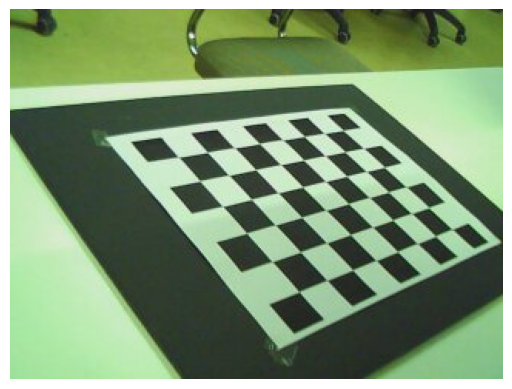

In [67]:
images = load_images_from_folder(f"{calibration_folder}/data", use_BGR=True)
show_from_list(images, 1)

In [68]:
# Find corners with cv2.findChessboardCorners() 

# Convert to gray images
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]

#Find corners
corners = [cv2.findChessboardCorners(image=img_gray, patternSize=SIZE) for img_gray in imgs_gray]

# Save found values
ret_values = [c[0] for c in corners]
print(f"Found corners in {sum(ret_values)} out of {len(ret_values)} images")
print(f"Failed images at indexes: {[i for i, v in enumerate(ret_values) if not v]}")

Found corners in 18 out of 19 images
Failed images at indexes: [0]


In [69]:
# Refine corners
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

corners_refined = [
    cv2.cornerSubPix(
        img_gray, cor[1], (3, 3), (-1, -1), criteria
    ) if cor[0] else []
    for img_gray, cor in zip(imgs_gray, corners_copy)
]


In [70]:
images_copy = copy.deepcopy(images)
shown_corners_refined = [
    cv2.drawChessboardCorners(
        image=img,
        patternSize=SIZE,
        corners=corner,
        patternWasFound=ret
    ) if ret else img
    for img, corner, ret in zip(images_copy, corners_refined, ret_values)
]

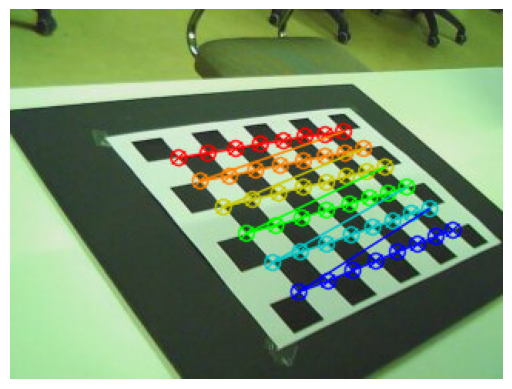

In [71]:
show_from_list(shown_corners_refined, index = 1)
write_images(shown_corners_refined, f"{calibration_folder}/results")

In [72]:
def get_chessboard_points(chessboard_shape, dx, dy):
    cols, rows = chessboard_shape 
    matrix = [(j * dx, i * dy, 0) for i in range(rows) for j in range(cols)]
    return np.array(matrix, np.float32)

In [73]:
points = get_chessboard_points(SIZE, dx, dy) 
chessboard_points = [points for ret in ret_values if ret]

# Filter data and get only those with adequate detections
valid_corners = [corner for corner, ret in zip(corners_refined, ret_values) if ret]

# Convert list to numpy array
valid_corners = np.asarray(valid_corners, dtype=np.float32)


### Get params

In [74]:
img_size = (np.array(imgs_gray)[0].shape[1], np.array(imgs_gray)[0].shape[0])
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    chessboard_points,
    valid_corners,
    img_size,
    None,
    None
)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

In [75]:
# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[420.61489679   0.         149.91923491]
 [  0.         421.68353326 128.43625502]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[-2.26269983e-02 -2.21483459e+00  4.36499520e-03 -6.74461069e-03
   1.18906006e+01]]
Root mean squared reprojection error:
 0.10276299773957971


In [76]:
"""
This is a json example of the camera parameters to be saved:
{
"camera": {
"intrinsics": [
    [419.17367964, 0.0, 149.87203907],
    [0.0, 420.67532299, 128.88566155],
    [0.0, 0.0, 1.0]
],
"distortion": [0.0254768626, -3.34669238, 0.00493017405, -0.00684826718, 20.0281254]
},
"color_ranges": {
"red": [[0, 120, 70], [10, 255, 255]],
"green": [[36, 100, 100], [86, 255, 255]],
"blue": [[94, 80, 2], [126, 255, 255]]
}
}

"""
# generate a json with the intrinsics and distortion coefficient
camera_params = {
    "camera": {
        "intrinsics": intrinsics.tolist(),
        "distortion": dist_coeffs.flatten().tolist()
    }
}
with open("calibration_1/camera_params.json", "w") as f:
    json.dump(camera_params, f, indent=4)
